# Project 2 

In [1]:
# Import libraries 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import numpy as np
import sqlite3
import sqlalchemy

## Prepare all the datasets and load the cleaned datasets


In [2]:
# Load the first cleaned dataset from Milestone 2
happiness = pd.read_csv("cleaned_happiness.csv")

In [3]:
# Check the dataset
happiness.head(5)

,Country,Rank_2018,Score_2018,Rank_2019,Score_2019,Rank_2020,Score_2020,Rank_2021,Score_2021,Rank_2022,Score_2022
0,Afghanistan,145.0,3.632,154,3.203,153.0,2.567,149.0,2.523,146.0,2.523
1,Albania,112.0,4.586,107,4.719,105.0,4.883,93.0,5.117,91.0,5.117
2,Algeria,84.0,5.295,88,5.211,100.0,5.005,109.0,4.887,107.0,4.887
3,Argentina,29.0,6.388,47,6.086,55.0,5.975,57.0,5.929,56.0,5.929
4,Armenia,129.0,4.321,116,4.559,116.0,4.677,86.0,5.283,84.0,5.283


In [4]:
happiness.columns

Index(['Country', 'Rank_2018', 'Score_2018', 'Rank_2019', 'Score_2019',
       'Rank_2020', 'Score_2020', 'Rank_2021', 'Score_2021', 'Rank_2022',
       'Score_2022'],
      dtype='object')

In [5]:
# Load the second cleaned dataset from Milestone 3
co2 = pd.read_csv("sorted_wiki.csv")
co2 = co2.drop(co2[co2['Country'] == 'World'].index)

In [6]:
# simplify columns names 
co2.rename(columns={
    'Fossil CO2 emissions (Mt CO2)': 'Fossil_CO2_emission_2017',
    'Fossil CO2 emissions (Mt CO2).1': 'Fossil_CO2_emission_2021',}, inplace=True)

In [7]:
# Check the dataset
co2.head(5)

,Country,Fossil_CO2_emission_2017,Fossil_CO2_emission_2021,Fossil CO2 emissions,2017 – Fossil CO2 emissions,2017 – Fossil CO2 emissions.1,2018 CO2 emissions,2018 CO2 emissions.1
0,Country,2017.000,2021.00,2017 (% of world),Per land area (t CO2/km2/yr),Per capita (t CO2/cap/yr),Total including LUCF[21],Total excluding LUCF[22]
2,China,10877.218,12466.32,29.34%,1.133,7.7,9663.36,10313.46
3,United States,5107.393,4752.08,13.77%,519.0,15.7,4749.57,4981.30
4,European Union,3548.345,2774.93,9.57%,793.0,7.0,2636.98,2871
5,India,2454.774,2648.78,6.62%,747.0,1.8,2400.25,2434.52


In [8]:
co2.columns

Index(['Country', 'Fossil_CO2_emission_2017', 'Fossil_CO2_emission_2021',
       'Fossil CO2 emissions', '2017 – Fossil CO2 emissions',
       '2017 – Fossil CO2 emissions.1', '2018 CO2 emissions',
       '2018 CO2 emissions.1'],
      dtype='object')

In [9]:
# Load the third cleaned dataset from Milestone 4
pollution = pd.read_csv("cleaned_api.csv")

In [10]:
# Check the dataset
pollution.head(5)

,country,CO,O3,NO2,PM5
0,United States of America,278.0,0.0,102.0,500.0
1,Democratic Republic of the Congo,176.0,1.0,71.0,500.0
2,Malaysia,67.0,209.0,2.0,157.0
3,South Africa,57.0,0.0,34.0,500.0
4,Chile,28.0,0.0,36.0,358.0


In [11]:
pollution.columns

Index(['country', 'CO', 'O3', 'NO2', 'PM5'], dtype='object')

## Load the dataset into database and join into one dataset

In [12]:
# Create database 
conn = sqlite3.connect("final.db")
cursor = conn.cursor()

In [13]:
# Clenaup and drop if there is existing table 
cursor.execute("DROP TABLE IF EXISTS happiness")
cursor.execute("DROP TABLE IF EXISTS co2")
cursor.execute("DROP TABLE IF EXISTS pollution")

In [14]:
# Create table with necessary information from happiness df
cursor.execute("CREATE TABLE IF NOT EXISTS happiness (country text, 'Score_2021' number, 'Rank_2021' number)")

In [15]:
# Create table with necessary information from co2 df
cursor.execute("CREATE TABLE IF NOT EXISTS co2 (country text,'Fossil_CO2_emission_2021' number)")

In [16]:
# Create table with necessary informatino from pollution df
cursor.execute("CREATE TABLE IF NOT EXISTS pollution (country text, CO number, O3 number)")

In [17]:
# Insert data into the tables 
happiness[['Country', 'Rank_2021', 'Score_2021']].to_sql('happiness', conn, if_exists='append', index=False)
co2[['Country', 'Fossil_CO2_emission_2021']].to_sql('co2', conn, if_exists='append', index=False)
pollution[['country', 'CO', 'O3']].to_sql('pollution', conn, if_exists='append', index=False)

175

In [18]:
conn.commit()

In [19]:
# Join table happiness to the co2
query_1 = """
SELECT happiness.country, Score_2021, co2.Fossil_CO2_emission_2021 
FROM happiness
LEFT JOIN co2 ON happiness.country = co2.country
"""
result_1 = cursor.execute(query_1).fetchall()
# Create a new df with the reasult
new_df1 = pd.DataFrame(result_1, columns=['Country', 'Score_2021', 'emissions_2021'])

In [20]:
# Test the result for the new df(happiness and co2)
new_df1

,Country,Score_2021,emissions_2021
0,Afghanistan,2.523,8.35
1,Albania,5.117,4.59
2,Algeria,4.887,173.00
3,Argentina,5.929,189.00
4,Armenia,5.283,6.77
...,...,...,...
144,Venezuela,4.892,104.67
145,Vietnam,5.411,321.41
146,Yemen,3.658,12.05
147,Zambia,4.073,7.01


In [21]:
# Join table with happiness and pollution
query = """
SELECT happiness.country, Score_2021, CO, O3
FROM happiness
LEFT JOIN pollution ON happiness.country = pollution.country
"""
result = cursor.execute(query).fetchall()
# Create a new df with the reasult
new_df2 = pd.DataFrame(result, columns=['Country', 'Score_2021', 'CO', 'O3'])

In [22]:
# Check the result for the new df(happiness and pollution)
new_df2

,Country,Score_2021,CO,O3
0,Afghanistan,2.523,3.0,77.0
1,Albania,5.117,1.0,43.0
2,Algeria,4.887,10.0,33.0
3,Argentina,5.929,7.0,0.0
4,Armenia,5.283,1.0,34.0
...,...,...,...,...
144,Venezuela,4.892,NaN,NaN
145,Vietnam,5.411,NaN,NaN
146,Yemen,3.658,6.0,60.0
147,Zambia,4.073,8.0,26.0


In [23]:
# Join All three tables (happiness, co2 and pollution)
query_3 = """
SELECT happiness.country, Score_2021, co2.Fossil_CO2_emission_2021, CO, O3
FROM happiness
LEFT JOIN co2 ON happiness.country = co2.country
LEFT JOIN pollution ON happiness.country = pollution.country
"""
result_3 = cursor.execute(query_3).fetchall()
# Create a new df with the reasult
new_df3 = pd.DataFrame(result_3, columns=['Country', 'Score_2021', 'Fossil_CO2_emission_2021', 'CO', 'O3'])

In [24]:
# Check the result for the new df(happiness, co2 and pollution)
new_df3

,Country,Score_2021,Fossil_CO2_emission_2021,CO,O3
0,Afghanistan,2.523,8.35,3.0,77.0
1,Albania,5.117,4.59,1.0,43.0
2,Algeria,4.887,173.00,10.0,33.0
3,Argentina,5.929,189.00,7.0,0.0
4,Armenia,5.283,6.77,1.0,34.0
...,...,...,...,...,...
144,Venezuela,4.892,104.67,NaN,NaN
145,Vietnam,5.411,321.41,NaN,NaN
146,Yemen,3.658,12.05,6.0,60.0
147,Zambia,4.073,7.01,8.0,26.0


In [25]:
conn.close()

## Visualization 

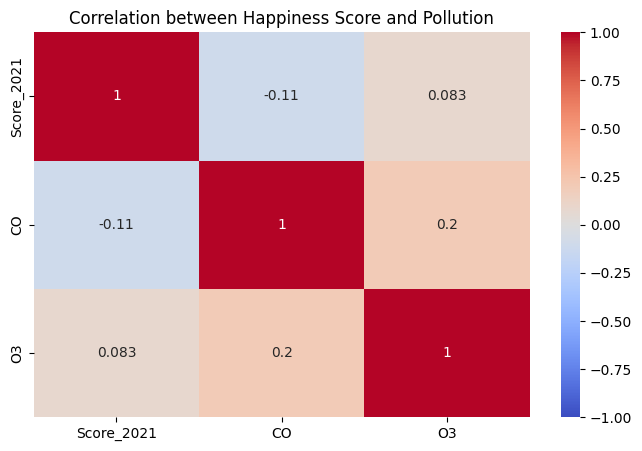

In [26]:
# Visualization 1 

# Calculating the correlation 
corr = new_df2[['Score_2021', 'CO', 'O3']].corr()

# Plotting the correlation heatmap
plt.figure(figsize=(8,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation between Happiness Score and Pollution")
plt.show()

In [27]:
# Visualization 2 

# Create a list of countries of interest
countries_of_interest = ['United Kingdom', 'China', 'India', 'Japan', 'Italy', 'Canada', 'France']
# Filter the data for these countries
filtered_data = happiness[happiness['Country'].isin(countries_of_interest)]

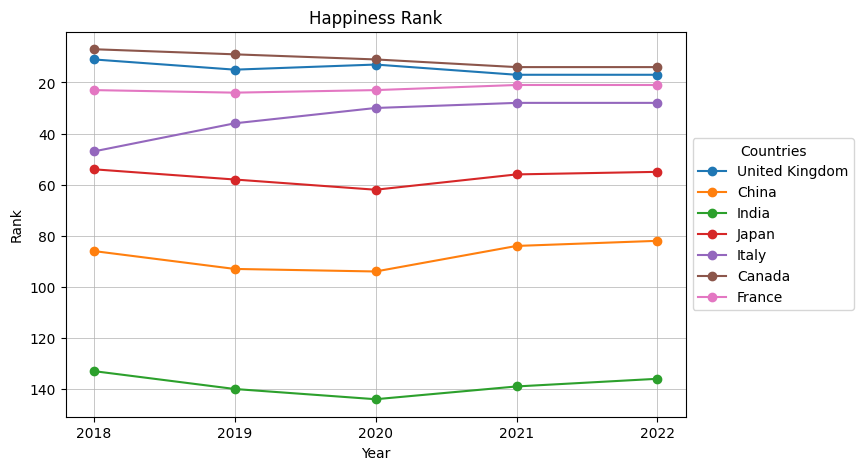

In [33]:
# Plotting with the rank of the happiness index and the changes in different years 
plt.figure(figsize=(8,5))
for country in countries_of_interest:
    country_data = filtered_data[filtered_data['Country'] == country]
    plt.plot(['2018', '2019', '2020', '2021', '2022'], country_data.iloc[0, 1::2], label=country, marker='o')

plt.gca().invert_yaxis()
plt.legend(title='Countries', loc='center left', bbox_to_anchor=(1, 0.5)) 
plt.title('Happiness Rank')
plt.xlabel('Year')
plt.ylabel('Rank')
plt.grid(True, linewidth=0.5)
plt.show()

In [34]:
# Visualization 3

# Also used the same countries from the previous visualization 
countries_of_interest = ['United Kingdom', 'China', 'India', 'Japan', 'Italy', 'Canada', 'France']
# Filter the data for these countries from the new df that just combined from previous section
filtered_data2 = new_df1[new_df1['Country'].isin(countries_of_interest)]

ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

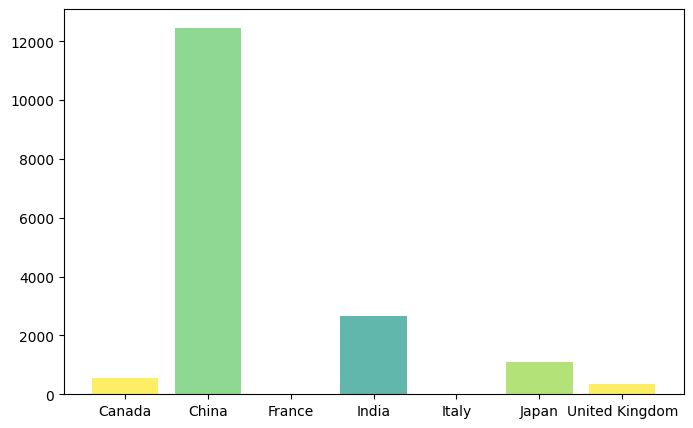

In [46]:
# Usins bar chart with color, and the color is based on the Happiness Score
plt.figure(figsize=(8,5))

bars = plt.bar(
    filtered_data2['Country'], 
    filtered_data2['emissions_2021'], 
    color=plt.cm.viridis(filtered_data['Score_2021'] / filtered_data['Score_2021'].max()), 
    alpha=0.7)
sm = ScalarMappable(cmap=plt.cm.viridis)
sm.set_array([])

# Adding a colorbar
cbar = plt.colorbar(sm, orientation='vertical')
cbar.set_label('Happiness Score (2021)', rotation=270, labelpad=20)

plt.xlabel('Country')
plt.ylabel('Fossil CO2 Emissions (2021)')
plt.title('Fossil CO2 Emissions vs Happiness Score(2021)')
plt.show()

In [36]:
# Visualization 4 

# Create a list for the top 10 countries who has highest pollution(highest emission of CO)
top_10_pollution = pollution.sort_values(by='CO', ascending=False).head(10)

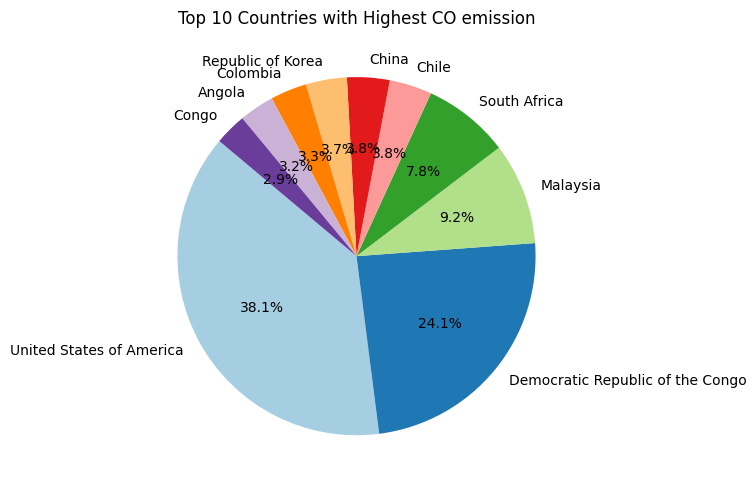

In [37]:
# Using Pie Chart to show the countries with the highest CO emission 
plt.figure(figsize=(8,5))
plt.pie(top_10_pollution['CO'], labels=top_10_pollution['country'], autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Top 10 Countries with Highest CO emission')
plt.tight_layout()
plt.show()

In [38]:
# Visualization 5

# Create list for the top 10 countries who has highest fossill co2 emission
top_10_co2 = co2.sort_values(by='Fossil_CO2_emission_2021', ascending=False).head(10)

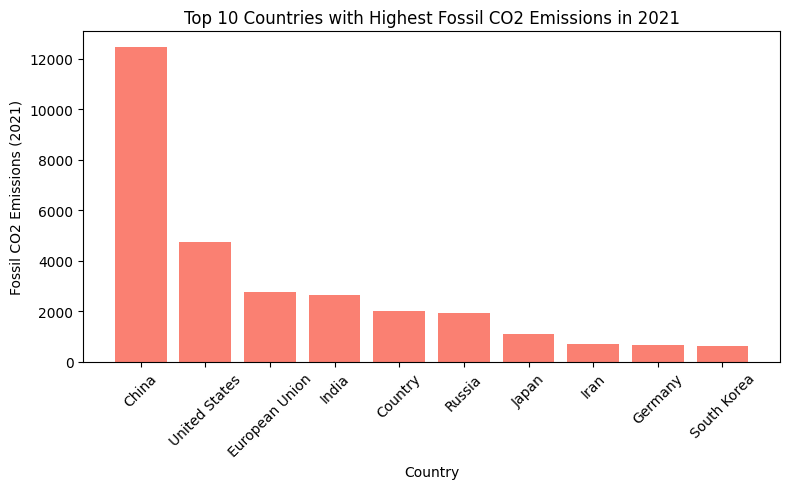

In [39]:
# Using bar chart to share the top 10 countries with the highest fossill CO2 emisison 
plt.figure(figsize=(8,5))
plt.bar(top_10_co2['Country'], top_10_co2['Fossil_CO2_emission_2021'], color='salmon')
plt.xlabel('Country')
plt.ylabel('Fossil CO2 Emissions (2021)')
plt.title('Top 10 Countries with Highest Fossil CO2 Emissions in 2021')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

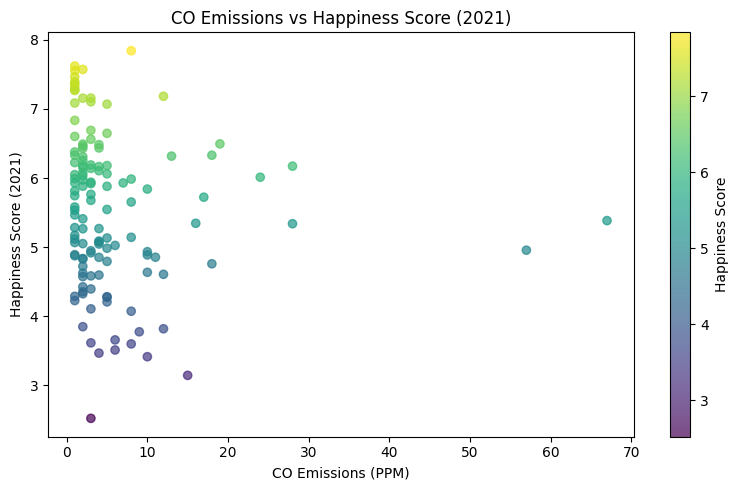

In [47]:
plt.figure(figsize=(8, 5))
plt.scatter(new_df3['CO'], new_df3['Score_2021'], c=new_df3['Score_2021'], cmap='viridis', alpha=0.7)

# Add labels and title
plt.xlabel('CO Emissions (PPM)')
plt.ylabel('Happiness Score (2021)')
plt.title('CO Emissions vs Happiness Score (2021)')
plt.colorbar(label='Happiness Score')

# Show the plot
plt.tight_layout()
plt.show()

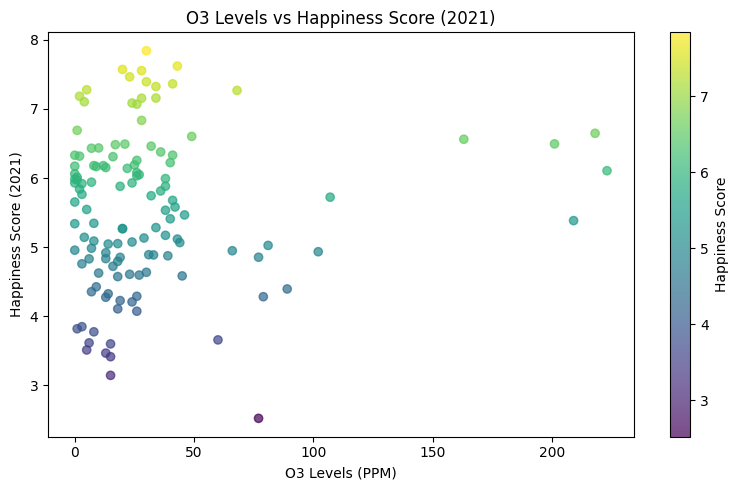

In [48]:
# Create the scatter plot
plt.figure(figsize=(8, 5))
plt.scatter(new_df3['O3'], new_df3['Score_2021'], c=new_df3['Score_2021'], cmap='viridis', alpha=0.7)

# Add labels and title
plt.xlabel('O3 Levels (PPM)')
plt.ylabel('Happiness Score (2021)')
plt.title('O3 Levels vs Happiness Score (2021)')
plt.colorbar(label='Happiness Score')

# Show the plot
plt.tight_layout()
plt.show()